In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.chdir('../')

In [2]:
from txt2img_latent import get_parser, load_model_from_config, chunk

parser = get_parser()

# 2) args_list 정의 (원하는 인자들을 문자열 리스트로)
args_list = [
    "--config", "configs/stable-diffusion/v1-inference.yaml",
    "--ckpt", "models/ldm/stable-diffusion-v1/sd-v1-4.ckpt",
    "--H", "512",
    "--W", "512",
    "--C", "4",
    "--f", "8",
]

# 3) parse_args() 실행
opt = parser.parse_args(args_list)

import torch
from omegaconf import OmegaConf

config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
print('done')

/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 13:14:30.272414: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 13:14:30.291570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 13:14:30.291595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 13:14:30

['/home/logpx/miniconda3/envs/rbf/lib/python311.zip', '/home/logpx/miniconda3/envs/rbf/lib/python3.11', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/lib-dynload', '', '/home/logpx/.local/lib/python3.11/site-packages', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages', '/home/logpx/scpark/dpm-solver-v32/codebases/stable-diffusion/src/taming-transformers', '/home/logpx/scpark/dpm-solver-v32/codebases/stable-diffusion/src/clip', '/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/setuptools/_vendor', '/tmp/tmpb44ap3zi']
Loading model from models/ldm/stable-diffusion-v1/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
done


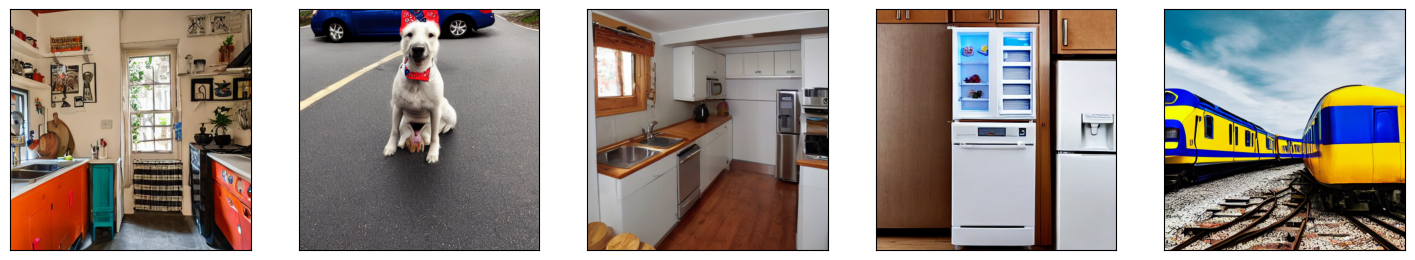

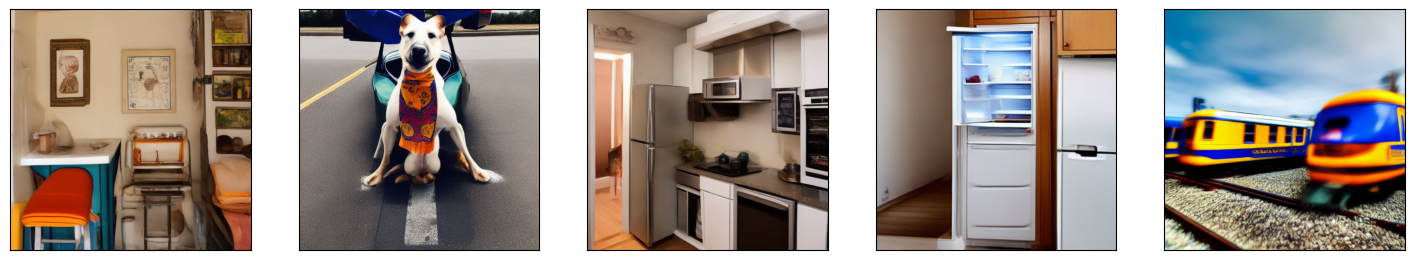

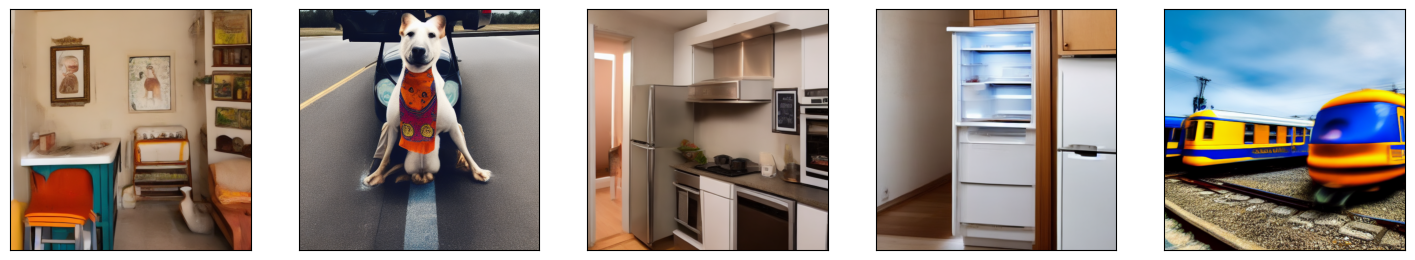

In [14]:
import numpy as np
import os
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from PIL import Image

def show_images(dir):
    pt_files = [os.path.join(dir, f) for f in os.listdir(dir) if '.pt' in f]
    data = torch.load(pt_files[1])
    image = data['image']

    x_samples = model.decode_first_stage(image.to(device))
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()

    x_image_torch = torch.from_numpy(x_samples).permute(0, 3, 1, 2)

    plt.figure(figsize=[18, 5])
    for i, x_sample in enumerate(x_image_torch):
        x_sample = 255.0 * rearrange(x_sample.cpu().numpy(), "c h w -> h w c")
        img = Image.fromarray(x_sample.astype(np.uint8))
        plt.subplot(1, len(x_image_torch), i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

        
show_images('/data/ldm/outputs/sd-v1-4/uni_pc_bh2_steps200_scale7.5')
show_images('/data/ldm/outputs/sd-v1-4/uni_pc_bh2_steps5_scale7.5')
show_images('/data/ldm/outputs/sd-v1-4/rbf_order2_steps5_scale7.5')